In [1]:
# import sys
# sys.path.append('../scripts')

In [2]:
from utils import *

# Game Collaboration Network

Which game developers and publishers are most interconnected through collaborative efforts, sharing resources, or co-producing games?

In [3]:
df = pd.read_csv('steam.csv', usecols=['developer', 'publisher'])
df = (
    df
    .dropna()
    .applymap(lambda x: x.split(';'))
    .explode('developer')
    .explode('publisher')
    .reset_index(drop=True)
)

In [4]:
devs = set(df.developer)
pubs = set(df.publisher)

# For color-coding in visualization
dev_pub = set.intersection(devs, pubs)
dev_only = set.difference(devs, pubs)
pub_only = set.difference(pubs, devs)

len(dev_pub), len(dev_only), len(pub_only)

In [27]:
edge_dict = {}

for idx, row in df.iterrows():
    pair = (row.developer, row.publisher)
    if (pair in edge_dict.keys()) or (pair[::-1] in edge_dict.keys()):
        if pair in edge_dict.keys():
            edge_dict[pair] += 1
        elif pair[::-1] in edge_dict.keys():
            edge_dict[pair[::-1]] += 1
    else:
        edge_dict[pair] = 1

In [36]:
df_weighted_edges = (
    pd.DataFrame(
        [(nodes[0], nodes[1], weight) for nodes, weight in edge_dict.items()],
        columns=['node1', 'node2', 'weight']
    )
    .sort_values('weight', ascending=False)
    .reset_index(drop=True)
)

In [75]:
retained_nodes = []
retained_edges = []
for num_games in range(20):
    df_filtered = df_weighted_edges[df_weighted_edges.weight > num_games]
    
    retained_nodes.append(len(set.union(
        set(df_filtered.node1), set(df_filtered.node2)
    )))
    retained_edges.append(len(df_filtered))

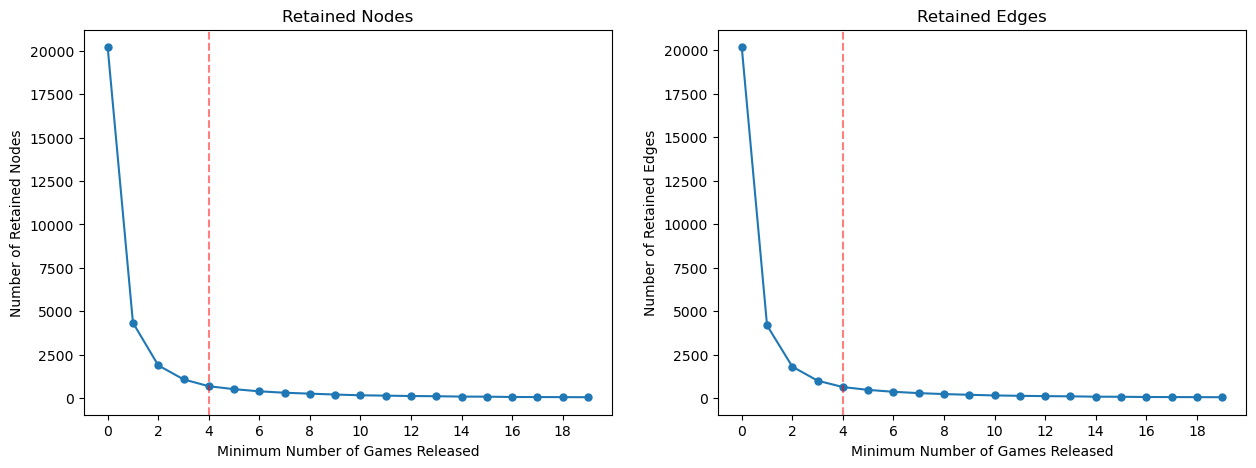

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for ax, retained, entity in zip(axes.flat,
                      [retained_nodes, retained_edges],
                      ['Nodes', 'Edges']):
    ax.plot(retained, marker='o', markersize=5)
    ax.set_title(f'Retained {entity}')
    ax.set_xlabel('Minimum Number of Games Released')
    ax.set_ylabel(f'Number of Retained {entity}')
    ax.set_xticks(range(0, 20, 2))
    ax.axvline(x=4, c='r', ls='--', alpha=0.5)
plt.show()